In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Predicting Passengers Who Survived or Not in Titanic Cruise


# 1. Problem Understanding

## 1.1. Problem Statement  
The sinking of the Titanic is one of the most infamous shipwrecks in history.  

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in **the death of 1502 out of 2224 passengers and crew**.  

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.  

## 1.2. Goals 

The goals of this machine learning project :  
- to know what sorts of people were more likely to survive or die of the Titanic disaster at the beginning of the 20th century 
- to know what features which the most influence the passengers to survive

## 1.3. Objective  
To achieve the goals, we have to take the actions through building a predictive model that answers the goals using passenger data (ie name, age, gender, socio-economic class, etc).

# 2. Exploratory Data Analysis (EDA)

## 2.1. Import Library

In [2]:
# Scientific Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
style.use('fivethirtyeight')
# Plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
# Booster for rendering
import plotly.io as pio
pio.renderers.default = 'iframe'

# Warning ignorance
import warnings
warnings.filterwarnings('ignore')

# Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, RobustScaler

# Selection
from scipy.stats import chi2_contingency

# Machine Learning Algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score,StratifiedKFold

# Metrics Evaluation
from sklearn.metrics import accuracy_score, precision_score 
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## 2.2. Load Dataset

In [3]:
# Import Train Dataset
train = pd.read_csv('/kaggle/input/titanic/train.csv')
# Import Test Dataset
test = pd.read_csv('/kaggle/input/titanic/test.csv')

## 2.3. Preview Data

In [4]:
# preview train dataset
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Preview test dataset
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 2.2. Data Shape

In [6]:
# Shape for train & test
print('Train dataset consists of ',train.shape[0],'rows &',
     train.shape[1],'columns')
print('Test dataset consists of ',test.shape[0],'rows &',
     test.shape[1],'columns')

Train dataset consists of  891 rows & 12 columns
Test dataset consists of  418 rows & 11 columns


## 2.3. Columns

In [7]:
print('Train columns :\n',train.columns,'\n')
print('Test columns :\n',test.columns)

Train columns :
 Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object') 

Test columns :
 Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


## 2.4. Data Information

In [8]:
# Get dataset information for train
print('Train information :\n')
print(train.info(),'\n')

Train information :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None 



<font size ='4'>**Summary :**</font>  
- Train dataset consists of 12 columns & 891 rows. Sample is only 40% from the actual number of passengers.
- Our target is `Survived`, others we call them features
- There are 3 data types, such as float, int, & object
- We can see that some of columns have missing values, such as `Age`, `Cabin`, & `Embarked`.
- Categorical : `Survived`,`Name`, `Sex`, `Ticket`, `Cabin`, `Embarked`, `Pclass`.
- Numerical : `PassengerId`, `Age`, `SibSp`, `Parch`, `Fare`.

In [9]:
# Get dataset information for test
print('Test information :\n')
print(test.info())

Test information :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


<font size ='4'>**Summary :**</font>  
- Test dataset consists of 11 columns & 418 rows.
- Target `Survived` is not available due to this data will be used to test our model
- We can see that some of columns have missing values, such as `Age`, `Cabin`, & `Fare.

## 2.5. Missing Values

In [10]:
# Identify missing values for train dataset
feature_train = train.isna().sum().keys().tolist()
missing_train = train.isna().sum().values.tolist()
mv_train = pd.DataFrame(list(zip(feature_train, missing_train)), 
                  columns=['feature','missing_value'])
mv_train['%missing'] = round(((mv_train['missing_value']/train.shape[0])*100),2)


# Identify missing values for test dataset
feature_test = test.isna().sum().keys().tolist()
missing_test = test.isna().sum().values.tolist()
mv_test = pd.DataFrame(list(zip(feature_test, missing_test)), 
                  columns=['feature','missing_value'])
mv_test['%missing'] = round(((mv_test['missing_value']/test.shape[0])*100),2)


print('Missing Values for Train Data \n',mv_train,'\n') 
print('Missing Values for Test Data \n',mv_test)

Missing Values for Train Data 
         feature  missing_value  %missing
0   PassengerId              0      0.00
1      Survived              0      0.00
2        Pclass              0      0.00
3          Name              0      0.00
4           Sex              0      0.00
5           Age            177     19.87
6         SibSp              0      0.00
7         Parch              0      0.00
8        Ticket              0      0.00
9          Fare              0      0.00
10        Cabin            687     77.10
11     Embarked              2      0.22 

Missing Values for Test Data 
         feature  missing_value  %missing
0   PassengerId              0      0.00
1        Pclass              0      0.00
2          Name              0      0.00
3           Sex              0      0.00
4           Age             86     20.57
5         SibSp              0      0.00
6         Parch              0      0.00
7        Ticket              0      0.00
8          Fare              1   

<font size ='4'>**Summary :**</font> 
- For train dataset, feature `cabin` has the highest missing value 77.10%, followed by `age` 19.87%, and the least is `Embarked` 0.22%.  If `cabin` is not correlated with the target, we'll drop it. 
- For test dataset, feature `cabin` also has the highest missing value 78.23% of data, followed by `age` 20.57%, & the least is `Fare`. 

In [11]:
# Checking zero values
for col in list(train.columns):
    print(col + '  ' + str(train[train[col]==0].shape[0]))

PassengerId  0
Survived  549
Pclass  0
Name  0
Sex  0
Age  0
SibSp  608
Parch  678
Ticket  0
Fare  15
Cabin  0
Embarked  0


<font size ='4'>**Summary :**</font>
- Survive is the target, 0 value is the passengers who didn't survive
- `SibSp` & `Parch`, 0 value means the passengers didn't travel with parent, children, sibling, or spouse
- `Fare` shouldn't has 0 value which means cruising for free, but maybe free for infant. let's dig more about this.

In [12]:
# Investigate how old the passengers who have 0 fare 
train[train['Fare']==0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


In [13]:
# Investigate how old the passengers who have 0 fare for test data 
test[test['Fare']==0]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
266,1158,1,"Chisholm, Mr. Roderick Robert Crispin",male,NaN,0,0,112051,0.0,NaN,S
372,1264,1,"Ismay, Mr. Joseph Bruce",male,49.0,0,0,112058,0.0,B52 B54 B56,S


<font size ='4'>**Summary :**</font>  
There are 17 passengers for both train & test dataset who have 0 for ticket fare. It looks all of these passengers are not infant, some have age data and some don't have age data. The conclusion that I'll fill these datas later.

## 2.6. Duplicated Values

In [14]:
# Check duplicated values based on all features
train.duplicated().sum()

0

In [15]:
# Check duplicated values based on selected features
check = ['PassengerId','Name','Ticket']
# Create looping to check
for col in check:
    print('Total duplicated for',col,': ', train.duplicated(subset=col).sum())

Total duplicated for PassengerId :  0
Total duplicated for Name :  0
Total duplicated for Ticket :  210


<font size ='4'>**Summary :**</font>  
There are 210 rows or around 23% duplicated values based on Ticket number.

## 2.7. Separate Numerical & Categorical Data

In [16]:
# Numerical data
nums = ['PassengerId', 'Age','SibSp', 'Parch', 'Fare']
# Categorical data
cats =['Survived','Pclass','Name', 'Sex', 'Ticket', 
       'Cabin', 'Embarked']

## 2.8. Univariate Analysis

### 2.8.1 Descriptive Statistic

In [17]:
# Only display numerical data
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<font size ='4'>**Summary :**</font>  
- The lowest age is around 4 months old or baby, and the highest is 80 years old. The average of age is 29 years old. Distribution of age looks normal.
- average of ticket fare are around $32. Fare distribution looks skewed.

In [18]:
# for categorical data
train.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Landergren, Miss. Aurora Adelia",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


<font size ='4'>**Summary :**</font>  
- Name is unique
- Around 65% passengers are male and the rests are female.
- Ticket number has around 23% duplicated values
- Cabin feature also has duplicated values, but we can assume that some passengers can share the cabin.
- Most of passengers embarked from Southampton Port.

### 2.8.2. Target Visualization

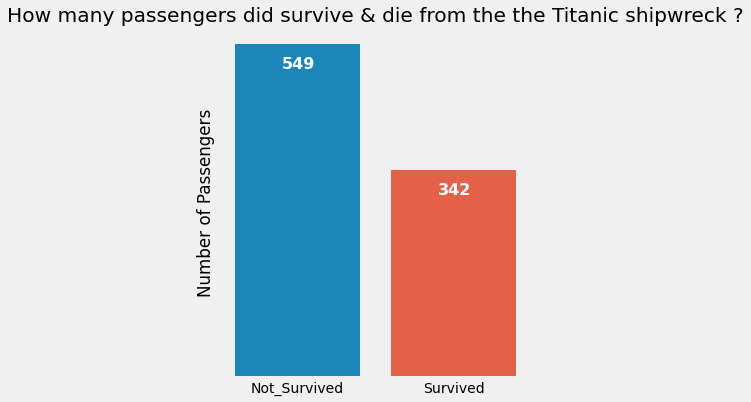

In [19]:
plt.figure(figsize=(5,6))
# Count plot
ax = sns.countplot(train['Survived']);
plt.xlabel('');
plt.ylabel('Number of Passengers');
plt.xticks([0,1],['Not_Survived','Survived']);
plt.yticks([],[]);
plt.title('How many passengers did survive & die from the the Titanic shipwreck ?')

# Annotation

for bar in ax.patches:
    total = format(bar.get_height(), '.0f')
    x = bar.get_x() + bar.get_width() / 2 - 0.1
    y = bar.get_y()-40 + bar.get_height()
    ax.annotate(total, (x, y), size = 16,
                weight='bold', color = 'w')

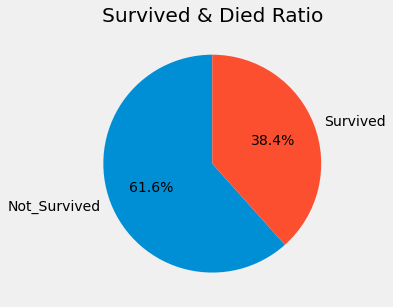

In [20]:
plt.figure(figsize=(20,5))
# Pie chart
plt.subplot(142)
train['Survived'].value_counts().plot.pie(
    autopct='%1.1f%%',startangle=90, 
    labels=['Not_Survived','Survived']);
plt.ylabel('');
plt.title('Survived & Died Ratio');

<font size ='4'>**Summary :**</font>  
- **38.4% Passengers or equal to 342 survived** from the Titanic shipwreck.
- **61.6% Passengers or equal to 342 died** from the Titanic shipwreck.

### 2.8.2. Histogram Plot

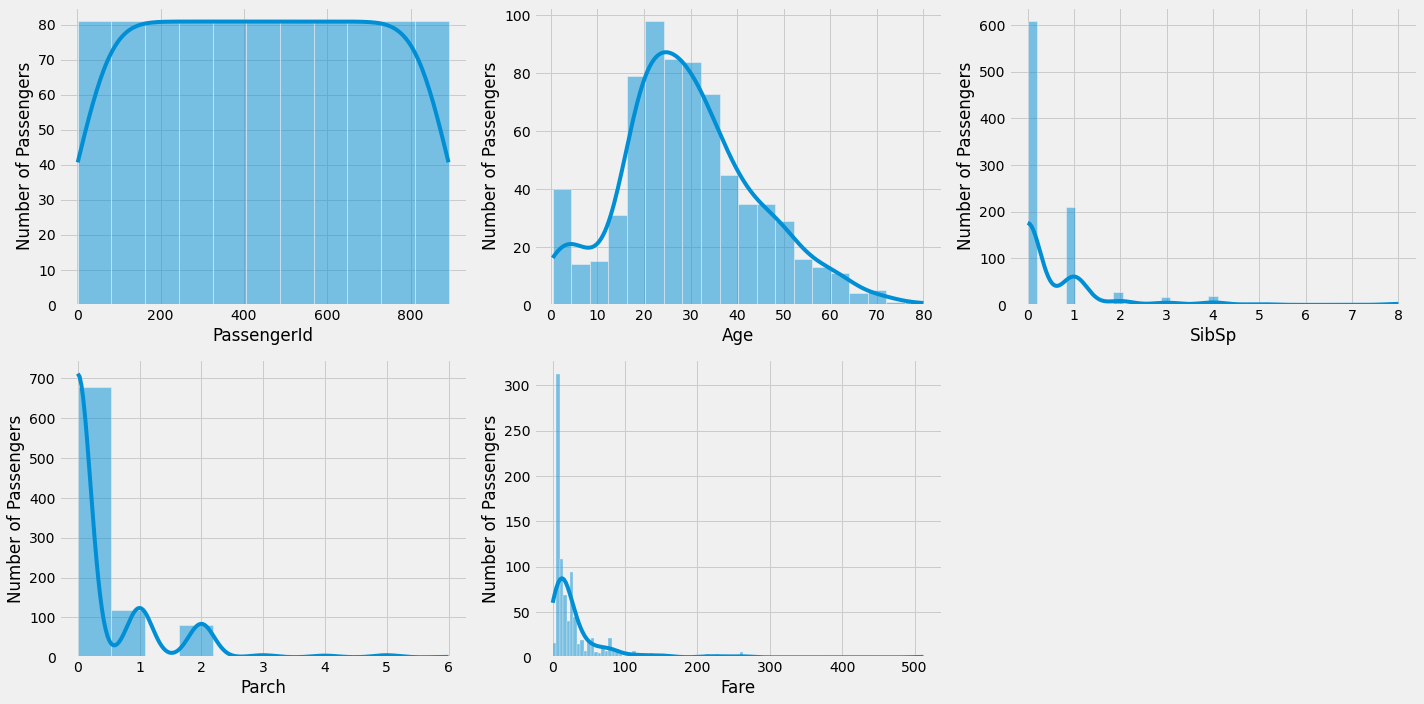

In [21]:
plt.figure(figsize=(20,10))
for i in range(0, len(nums)):
    plt.subplot(2,3, i+1)
    sns.histplot(train[nums[i]], kde = True);
    plt.ylabel('Number of Passengers')
    plt.tight_layout();

<font size ='4'>**Summary :**</font>  
Feature `SibSp`, `Parch`, & `Fare` have right-skewed distribution. We'll visualize box plot to identify the outlier.

### 2.8.3. Box Plot

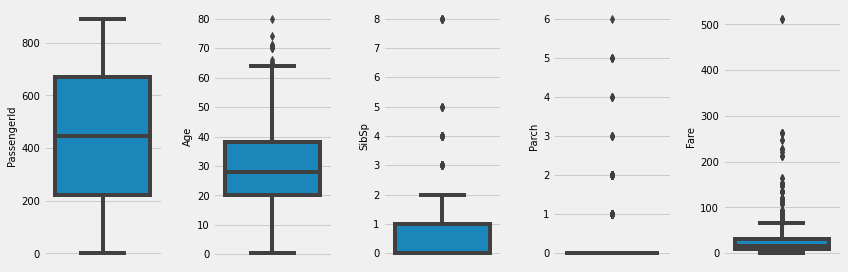

In [22]:
plt.figure(figsize=(12,4))
for i in range(0,len(nums)):
    plt.subplot(1, len(nums), i+1)
    sns.boxplot(y = train[nums[i]])
    plt.ylabel(nums[i],size=10)
    plt.yticks(size = 10)
    plt.tight_layout()

Apart from the distributions, the range of values is also an important aspect of features. The above plot tell us that the features have different scales. We also can identify outlier values, like `Age`, `SibSp`, `Parch`, & `Fare` have outlier values. 

In [23]:
# Identify total outlier using IQR
for col in nums:
    
    # Menghitung nilai IQR
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define value 
    nilai_min = train[col].min()
    nilai_max = train[col].max()
    lower_lim = Q1 - (1.5*IQR)
    upper_lim = Q3 + (1.5*IQR)
    
    # Identify low outlier

    if (nilai_min < lower_lim):
        print('Low outlier is found in column',col,'<', lower_lim,'\n')
        #display total low outlier 
        print('Total of Low Outlier in column',col, ':', len(
            list(train[train[col] < lower_lim].index)),'\n')
    elif (nilai_max > upper_lim):
        print('High outlier is found in column',col,'>', upper_lim,'\n')
        #display total high outlier 
        print('Total of High Outlier in column',col, ':', len(
            list(train[train[col] > upper_lim].index)),'\n')
        
    else:
        print('Outlier is not found in column',col,'\n')   

Outlier is not found in column PassengerId 

High outlier is found in column Age > 64.8125 

Total of High Outlier in column Age : 11 

High outlier is found in column SibSp > 2.5 

Total of High Outlier in column SibSp : 46 

High outlier is found in column Parch > 0.0 

Total of High Outlier in column Parch : 213 

High outlier is found in column Fare > 65.6344 

Total of High Outlier in column Fare : 116 



total outlier values are 386 or 43% of the dataset.

### 2.8.4. Categorical Plot

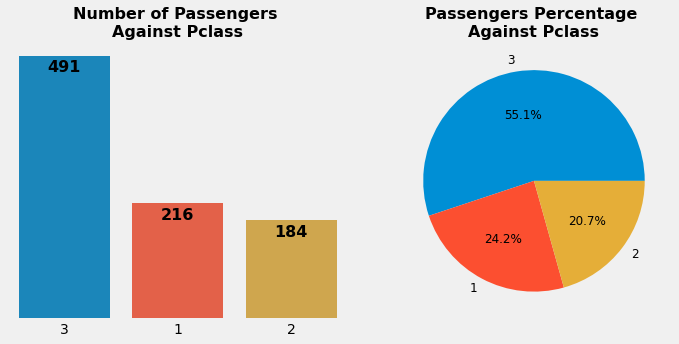

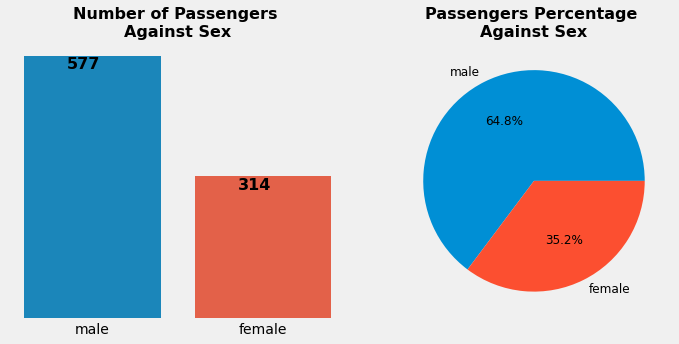

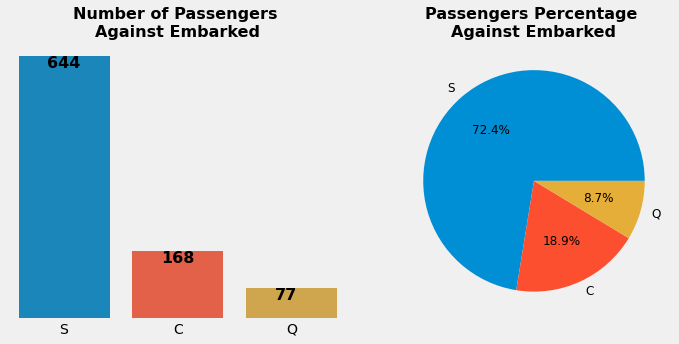

In [24]:
categorical = ['Pclass','Sex','Embarked']
# Looping for countplot
for col in categorical:
    plt.figure(figsize=(20, 5))
    # Countplot
    plt.subplot(141);
    ax = sns.countplot(x = train[col], 
                       order=train[col].value_counts().index);
    
    for p in ax.patches:
        value = format(p.get_height(), '.0f') 
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height() - 30
        ax.annotate(value, (x, y), size = 16, weight='bold')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([],[])
    plt.title('Number of Passengers \nAgainst '+col, size = 16, weight = 'bold')
    plt.tight_layout();
    
    # Pie chart
    plt.subplot(142);
    train[col].value_counts().plot.pie(
        autopct='%1.1f%%', textprops={'fontsize': 12}); 
    plt.title('Passengers Percentage \nAgainst '+col, size = 16, weight = 'bold')
    plt.ylabel('');

<font size ='4'>**Summary :**</font>

- around 50% of passengers are from lower socio-economic, followed by upper passengers 24.2%, and the least passengers from middle class.
- 64.8% passengers are male, and the rests are female.
- 72.4% passengers embarked from Southampton Port, followed by Cherbourg Port 18.9%, and 8.7% passengers embarked from Queenstown Port.

## 2.9. Multivariate Analysis

### 2.9.1. Heatmap Correlation

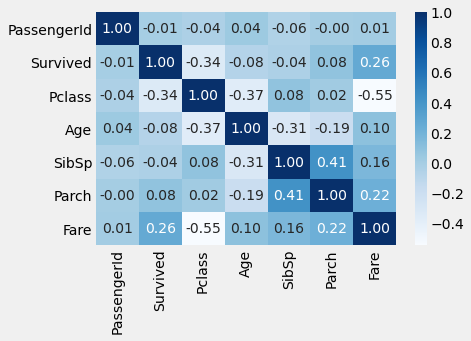

In [25]:
sns.heatmap(train.corr(), cmap = 'Blues', fmt='.2f', annot=True);

<font size ='4'>**Summary :**</font>

- Target `Survived` has positive correlation with `Fare` and negative correlation with `Pclass`, but both of them are weak correlation. It means that the upper class passengers & costly ticket tend to survive.
- Feature `Pclass` has moderate negative correlation with `Fare` & `Age`. The higher passengers class the more expensive ticket. And upper class passengers are mostly not dominated with young people.
- Feature `SibSp` has moderate positive correlation with `Parch` and weak negative correlation with `Age` & `Fare`.

### 2.9.2. Pair Plot

<Figure size 504x504 with 0 Axes>

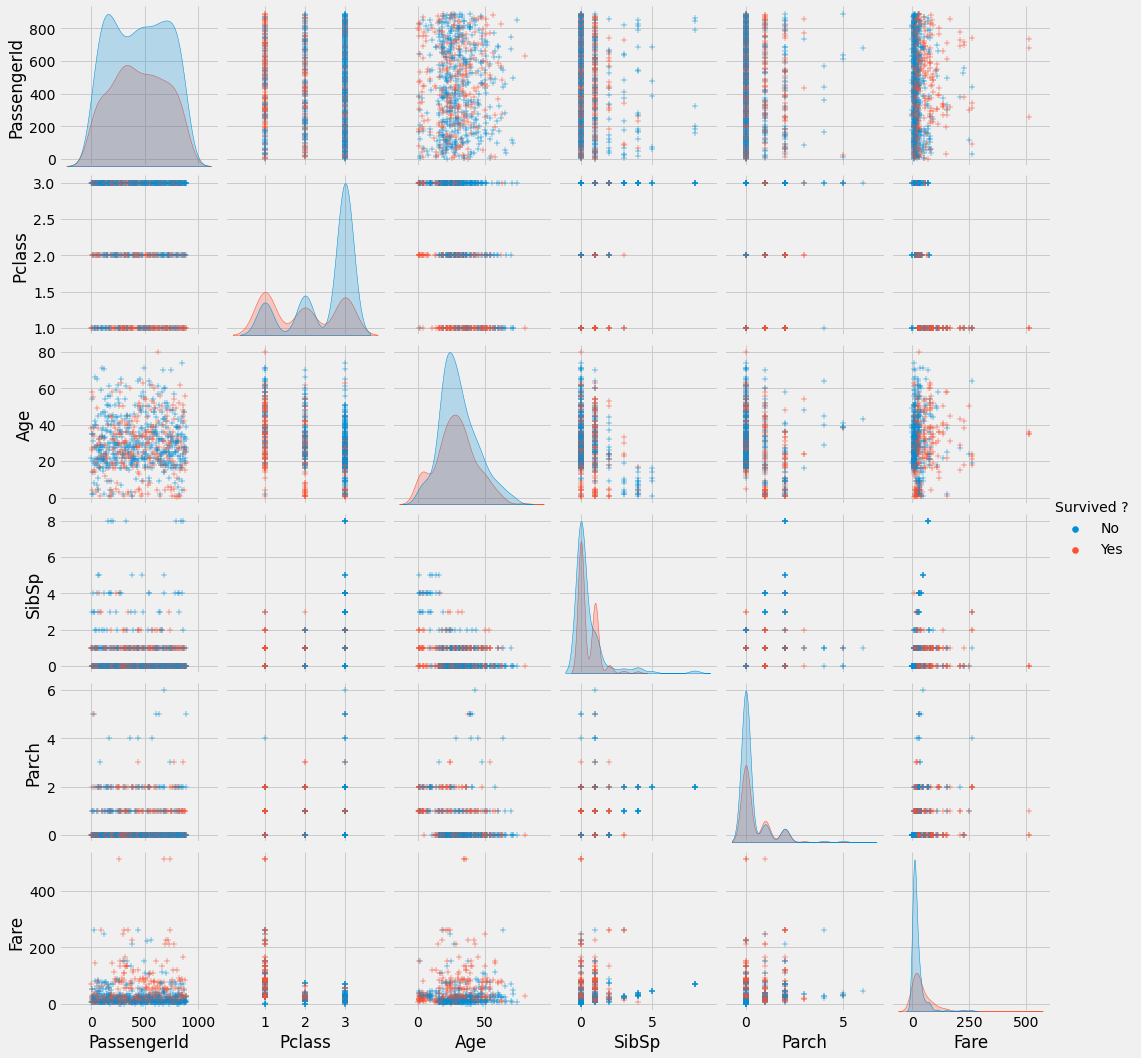

In [26]:
plt.figure(figsize=(7,7))
p=sns.pairplot(train, markers = '+', diag_kind = 'kde', 
                 hue = 'Survived');
# title
new_title = 'Survived ?'
p._legend.set_title(new_title);

# replace labels
new_labels = ['No', 'Yes']
for t, l in zip(p._legend.texts, new_labels): t.set_text(l);

<font size ='4'>**Summary :**</font>

- The upper-class passengers are tend to survive than middle & lower class. The passengers in the range of age between 0.42 months - 60 years old and traveled with their families had a greater chance to survive. You will get what you pay!
- The more families the less chance to survive

### 2.9.3. Plot With Hue = 'Survived'

In [27]:
def barplot(data,feature, num_or_str) :
    
    bar1 = data[(data['Survived'] == 0)]
    bar2 = data[(data['Survived'] != 0)]
    ratio = pd.DataFrame(pd.crosstab(data[feature],train['Survived']), )
    ratio['%_survived'] = round((ratio[1] / (ratio[1] + ratio[0]) * 100),2)
    if num_or_str == True:
        ratio = ratio.sort_values(0, ascending = False)

    
    trace1 = go.Bar(x=bar1[feature].value_counts().keys().tolist(),
                    y=bar1[feature].value_counts().values.tolist(),
                    name='Not_Survived',opacity = 0.8, marker=dict(
                    color='green'))

    
    trace2 = go.Bar(x=bar2[feature].value_counts().keys().tolist(),
                    y=bar2[feature].value_counts().values.tolist(),
                    name='Survived', opacity = 0.8, marker=dict(
                    color='red'))
    
    trace3 =  go.Scatter(x=ratio.index, y=ratio['%_survived'], 
                         yaxis = 'y2', name='% Survived', 
                         opacity = 0.6, marker=dict(color='black',
                                                    line=dict(color='#000000',width=0.5)))

    layout = dict(title =  str(feature)+' Against Survived',xaxis=dict(), 
                  yaxis=dict(title= 'Number of Passengers'), 
                  yaxis2=dict(autorange= True, 
                              overlaying= 'y', 
                              anchor= 'x', 
                              side= 'right',
                              zeroline=False,
                              showgrid= False,
                              title= '% Survived'))

    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    py.iplot(fig)
    
def single_hist(x,hue):
    hist = sns.histplot(data=train, x=x, hue=hue, kde=True);
    return (hist)

def hist_kde(key,value,x,hue):
    plt.figure(figsize=(15,5))
    sex = train[train[key]==value]
    kde = sns.histplot(data=sex, x=x, hue=hue, kde=True);
    plt.tight_layout()
    return(kde)

<font size='4'>**Which Gender Had Better Chance to Survive**</font>

In [28]:
barplot(train,'Sex',True)

<font size='3.8'>*Women are more likely to survive compared to men*</font>

<font size='4'>**How about age distribution against survived ?**</font>

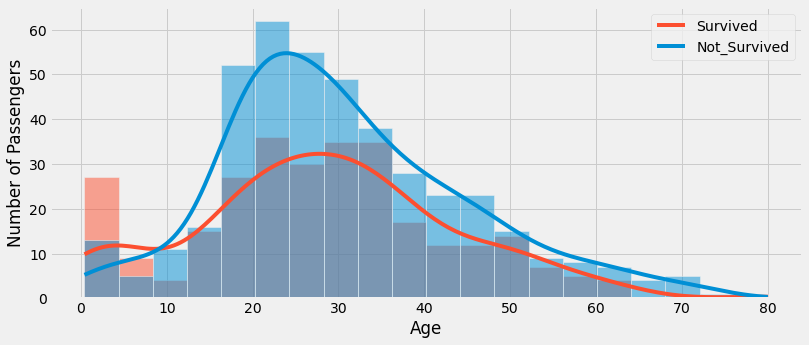

In [29]:
plt.figure(figsize=(12,5))
single_hist('Age','Survived');
plt.legend(['Survived','Not_Survived']);
plt.ylabel('Number of Passengers');

No passangers survived in the range of age more than 64 and less than 80 years old.

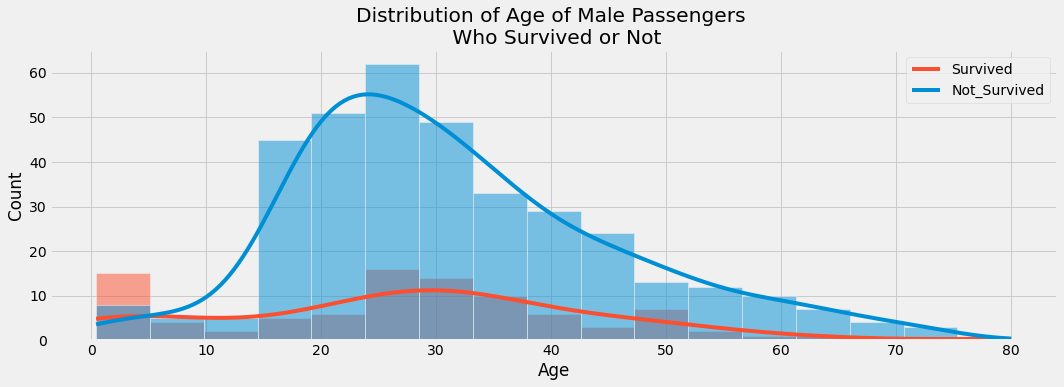

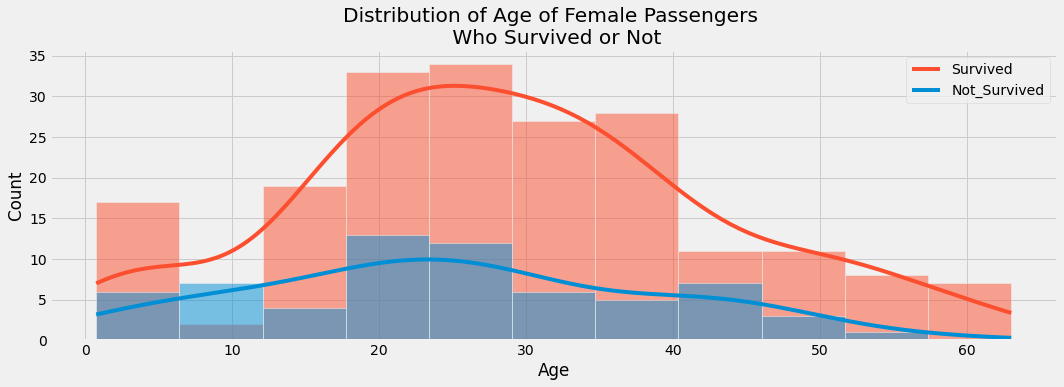

In [30]:
# Distribution of Age of Male Passengers against Survived
hist_kde('Sex','male','Age','Survived');
plt.legend(['Survived','Not_Survived']);
plt.title('Distribution of Age of Male Passengers \n Who Survived or Not');

# Distribution of Age of Female Passengers against Survived
hist_kde('Sex','female','Age','Survived');
plt.legend(['Survived','Not_Survived']);
plt.title('Distribution of Age of Female Passengers \n Who Survived or Not');

Probability of male passengers to survived are lower than female, especially in the range of age 15 - 55. But we can see that male passenger who under 5 years old can survive better.

<font size='4'>**Do the number of parents & children influence to survived ?**</font>

In [31]:
barplot(train,'Parch',False)

<font size='3.8'>*Number of parents or children influence to survive. The passengers who traveled with more 3 parents or children are tend to die, especially none survived with 4 or 6 parents or children*</font>

<font size='4'>**Do the number of siblings & spouse influence to survived ?**</font>

In [32]:
barplot(train,'SibSp',False)

<font size='3.8'>*Number of sibings & spouse influence to survive. The more siblings or spouse aboard the less chance to survive. The survived ratio starts decreasing after 1, it means that the passengers who traveled with more 1 sibling/spouse are hard to survive.*</font>

<font size='4'>**Do the more expensive ticket fares influence to survive?**</font>

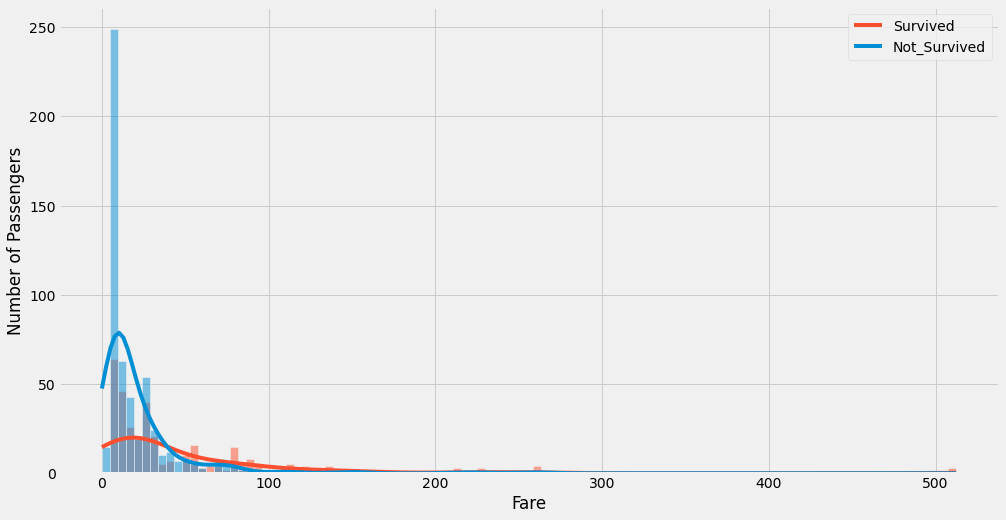

In [33]:
plt.figure(figsize=(15,8))
single_hist('Fare','Survived')
plt.legend(['Survived','Not_Survived']);
plt.ylabel('Number of Passengers');

<font size='3.8'>*The passengers who bought ticket under 100 dollars are more likely to die, while the passengers with the ticket more than 270 dollars can survive. It seems that there are outlier values in this feature*</font>

<font size='4'>**The passengers who boarded from which port survived the most ?**</font>

In [34]:
barplot(train,'Embarked',True)

<font size='3.8'>*Passengers embarked from Cherbourg Port had the highest survived ratio compared to others, while the least who embarked from Queenstown Port*</font>

# 3. Data Pre Processing

In [35]:
# Duplicate dataframe for pre processing
tr_pr1 = train.copy()
ts_pr1 = test.copy()

## 3.1. Data Cleaning

### 3.1.1. Drop Irrelevant Features

In [36]:
# Drop PassengerID both train & test data
tr_pr1.drop('PassengerId',1, inplace=True) # Train data
ts_pr1.drop('PassengerId',1, inplace=True) # Test data

### 3.1.2. Handle Missing Values

<font size='3.5'>There are 4 features with the missing values, such as `Age`, `Cabin`, `Fare`, & `Embarked`.</font>

<font size='4'>**Train Data**</font>

In [37]:
# Dropna Embarked
tr_pr1.dropna(subset=['Embarked'],inplace=True)

# Fillna Age with mean
tr_pr1['Age'].fillna(tr_pr1['Age'].mean(),inplace=True)

# Fillna Cabin with 0
tr_pr1['Cabin'].fillna(0,inplace=True)

# Replace 0 values in Fare with median due to the distribution is skewed
median_fare = tr_pr1['Fare'].median(skipna=True)
tr_pr1['Fare']=tr_pr1.Fare.mask(tr_pr1.Fare == 0,median_fare)

In [38]:
# Check the missing values
feature = tr_pr1.isna().sum().keys().tolist()
missing = tr_pr1.isna().sum().values.tolist()
mv_check = pd.DataFrame(list(zip(feature, missing)), 
                  columns=['feature','missing_value'])
mv_check['%missing'] = round(((mv_check['missing_value']/train.shape[0])*100),2)
mv_check

,feature,missing_value,%missing
0,Survived,0,0.0
1,Pclass,0,0.0
2,Name,0,0.0
3,Sex,0,0.0
4,Age,0,0.0
5,SibSp,0,0.0
6,Parch,0,0.0
7,Ticket,0,0.0
8,Fare,0,0.0
9,Cabin,0,0.0


**All missing values for train data have been handled.**

<font size='4'>**Test Data**</font>

In [39]:
# Fillna Age with mean
ts_pr1['Age'].fillna(ts_pr1['Age'].mean(),inplace=True)

# Fillna Cabin with 0
ts_pr1['Cabin'].fillna(0,inplace=True)

# Fillna Fare with median
ts_pr1['Fare'].fillna(ts_pr1['Fare'].median(), inplace=True)

# Replace 0 values in Fare with median 
fare = ts_pr1['Fare'].median(skipna=True)
ts_pr1['Fare']=ts_pr1.Fare.mask(ts_pr1.Fare == 0,fare)

In [40]:
ts_pr1.isna().sum()

Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64

**All missing values for test data have been handled.**

### 3.1.3. Drop Duplicated Values

In [41]:
# Drop duplicated values for train data
tr_pr1.drop_duplicates(subset='Ticket', inplace=True)

## 3.2. Feature Engineering  

### 3.2.1. Extraction

In [42]:
# Create function to get total_cabin
def total_cabin(data):
    # Get total cabin for each passenger
    list_total = [] # Initiate empty list
    for i,row in data.iterrows(): # looping in every rows in dataframe
        if row['Cabin']== 0:        # if the value is 0
            total = 0               # total cabin is 0
        else:                                         # if the value isn't 0
            total = len(str(row['Cabin']).split(' ')) # we'll sum the cabin for every passenger 
        list_total.append(total) # add the empty list with the total value 
    data['total_cabin'] =  list_total

In [43]:
# Create function to extract cabin_location
def cabin_loc(data):
    # Get cabin type for each passenger
    list_loc = []
    for i, row in data.iterrows():
        if row['Cabin'] == 0:
            cabin_loc = 'No Cabin'
        else:
            cabin_loc = str(row['Cabin'])[0]
        list_loc.append(cabin_loc)
    data['cabin_loc'] = list_loc

In [44]:
# Create function to extract title from Name column
def title(data):
    list_title = []
    for i, row in data.iterrows():
        title = row['Name'].split(',')[1].split('.')[0]
        list_title.append(title)
    data['Title'] = list_title

<font size='4'>**Train Data**</font>

In [45]:
# Get total cabin for each passenger
total_cabin(tr_pr1)

In [46]:
tr_pr1['total_cabin'].value_counts()

0    544
1    125
2      8
3      2
4      1
Name: total_cabin, dtype: int64

In [47]:
# Total Cabin against Survived
pd.pivot_table(tr_pr1, index = 'Survived', columns = 'total_cabin',
               values = 'Name' ,aggfunc ='count')

total_cabin,0,1,2,3,4
Survived,,,,,
0,389.0,46.0,5.0,2.0,NaN
1,155.0,79.0,3.0,NaN,1.0


In [48]:
total_cabin_gr = tr_pr1.groupby(['total_cabin','Survived'])['Name'].count().reset_index()
total_cabin_gr.rename(columns={'Name':'Passenger'}, inplace=True)
total_cabin_gr['Total_Passenger'] = total_cabin_gr.groupby(['total_cabin'])['Passenger'].transform('sum')
total_cabin_gr['Ratio %'] = round(((total_cabin_gr['Passenger'] / total_cabin_gr['Total_Passenger'])*100),2)
total_cabin_gr

,total_cabin,Survived,Passenger,Total_Passenger,Ratio %
0,0,0,389,544,71.51
1,0,1,155,544,28.49
2,1,0,46,125,36.80
3,1,1,79,125,63.20
4,2,0,5,8,62.50
5,2,1,3,8,37.50
6,3,0,2,2,100.00
7,4,1,1,1,100.00


<font size ='4'>**Summary :**</font>  
- Passengers who didn't have cabin were more likely to survive
- No passenger survived with 3 cabin
- No passenger died with 4 cabin

In [49]:
# Get cabin loc for each passenger
cabin_loc(tr_pr1)

In [50]:
tr_pr1['cabin_loc'].value_counts()

No Cabin    544
C            35
B            26
E            25
D            24
A            13
F            10
G             2
T             1
Name: cabin_loc, dtype: int64

In [51]:
# Cabin Location against Survived
pd.pivot_table(tr_pr1, index = 'Survived', columns = 'cabin_loc',
               values = 'Name' ,aggfunc ='count')

cabin_loc,A,B,C,D,E,F,G,No Cabin,T
Survived,,,,,,,,,
0,7.0,10.0,15.0,6.0,8.0,5.0,1.0,389.0,1.0
1,6.0,16.0,20.0,18.0,17.0,5.0,1.0,155.0,NaN


<font size ='4'>**Summary :**</font>  
- Passengers who didn't have cabin were more likely to survive
- No passenger survived in deck T


In [52]:
# Get the passengers' title
title(tr_pr1)

In [53]:
tr_pr1['Title'].value_counts()

 Mr          443
 Miss        129
 Mrs          71
 Master       16
 Dr            6
 Rev           5
 Major         2
 Col           2
 Mlle          1
 Ms            1
 Lady          1
 Don           1
 Jonkheer      1
 Mme           1
Name: Title, dtype: int64

In [54]:
# Passengers' title against Survived
pd.pivot_table(tr_pr1, index = 'Survived', columns = 'Title',
               values = 'Name' ,aggfunc ='count')

Title,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev
Survived,,,,,,,,,,,,,,
0,1.0,1.0,4.0,1.0,NaN,1.0,7.0,34.0,NaN,NaN,375.0,13.0,NaN,5.0
1,1.0,NaN,2.0,NaN,1.0,1.0,9.0,95.0,1.0,1.0,68.0,58.0,1.0,NaN


<font size ='4'>**Summary :**</font>  
The greater title of Passengers didn't guarantee they survived

<font size='4'>**Test Data**</font>  
I also extract in Test data for modelling purpose.

In [55]:
# Get total cabin for each passenger
total_cabin(ts_pr1)

In [56]:
# Get cabin type for each passenger
cabin_loc(ts_pr1)

In [57]:
# Get the passengers' title
title(ts_pr1)

### 3.2.2. Log Transformation

<font size='4'>**Train Data**</font>  

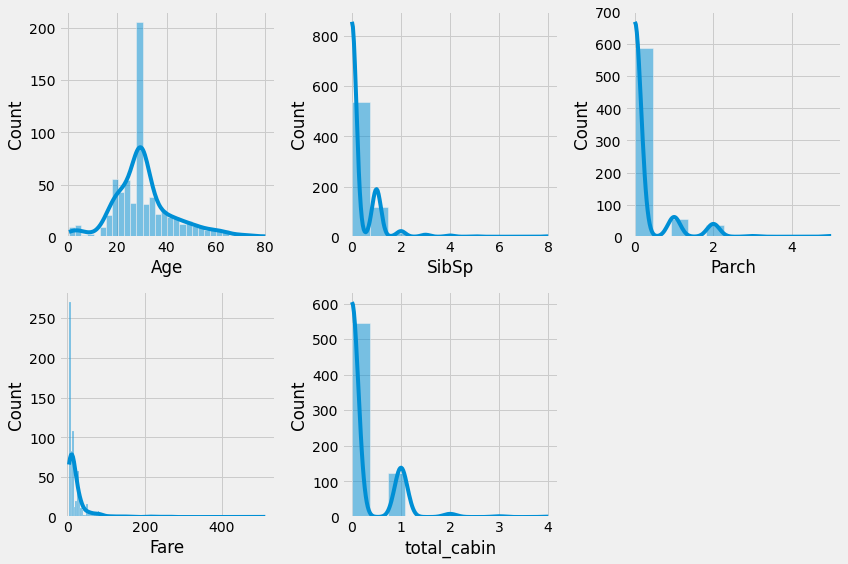

In [58]:
new_num = ['Age', 'SibSp', 'Parch','Fare','total_cabin']
plt.figure(figsize=(12,8))
for i in range(0, len(new_num)):
    plt.subplot(2,3, i+1)
    sns.histplot(tr_pr1[new_num[i]], kde=True)
    plt.tight_layout()

In [59]:
# Apply log transformation
tr_pr1['SibSp_log'] = (tr_pr1['SibSp']+1).apply(np.log)
tr_pr1['Parch_log'] = (tr_pr1['Parch']+1).apply(np.log)
tr_pr1['Fare_log'] = (tr_pr1['Fare']+1).apply(np.log)
tr_pr1['total_cabin_log'] = (tr_pr1['total_cabin']+1).apply(np.log)

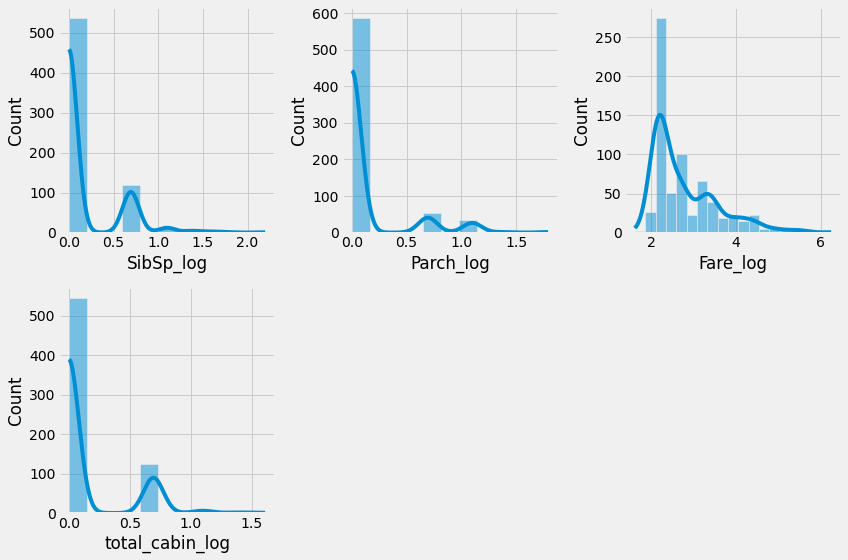

In [60]:
log_num = ['SibSp_log', 'Parch_log','Fare_log','total_cabin_log']
plt.figure(figsize=(12,8))
for i in range(0, len(log_num)):
    plt.subplot(2,3, i+1)
    sns.histplot(tr_pr1[log_num[i]], kde=True)
    plt.tight_layout()

<font size='4'>**Test Data**</font>  

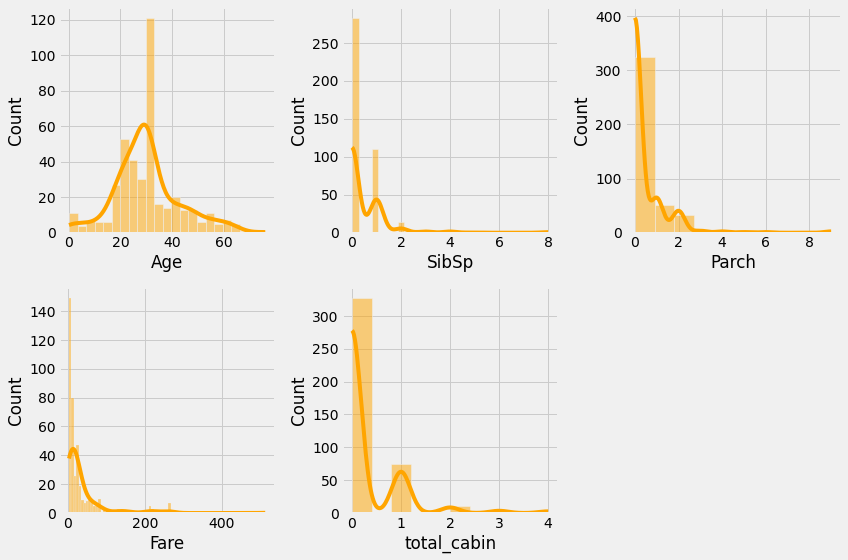

In [61]:
plt.figure(figsize=(12,8))
for i in range(0, len(new_num)):
    plt.subplot(2,3, i+1)
    sns.histplot(ts_pr1[new_num[i]], kde=True, color = 'Orange')
    plt.tight_layout()

In [62]:
# Apply log transformation
ts_pr1['SibSp_log'] = (ts_pr1['SibSp']+1).apply(np.log)
ts_pr1['Parch_log'] = (ts_pr1['Parch']+1).apply(np.log)
ts_pr1['Fare_log'] = (ts_pr1['Fare']+1).apply(np.log)
ts_pr1['total_cabin_log'] = (ts_pr1['total_cabin']+1).apply(np.log)

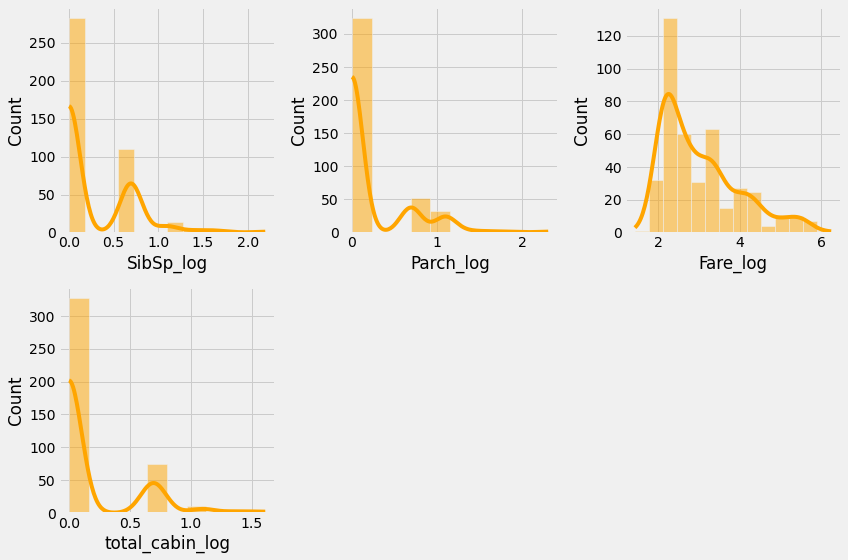

In [63]:
plt.figure(figsize=(12,8))
for i in range(0, len(log_num)):
    plt.subplot(2,3, i+1)
    sns.histplot(ts_pr1[log_num[i]], kde=True, color='Orange')
    plt.tight_layout()

### 3.2.3. Scaling

In [64]:
# Scaling for Train data
tr_pr1['Age_scale'] = RobustScaler().fit_transform(tr_pr1['Age'].values.reshape(len(tr_pr1), 1))
tr_pr1['SibSp_scale'] = RobustScaler().fit_transform(tr_pr1['SibSp_log'].values.reshape(len(tr_pr1), 1))
tr_pr1['Parch_scale'] = RobustScaler().fit_transform(tr_pr1['Parch_log'].values.reshape(len(tr_pr1), 1))
tr_pr1['Fare_scale'] = RobustScaler().fit_transform(tr_pr1['Fare_log'].values.reshape(len(tr_pr1), 1))
tr_pr1['total_cabin_scale'] = StandardScaler().fit_transform(tr_pr1['total_cabin_log'].values.reshape(len(tr_pr1), 1))

In [65]:
# Scaling for Test data
ts_pr1['Age_scale'] = RobustScaler().fit_transform(ts_pr1['Age'].values.reshape(len(ts_pr1), 1))
ts_pr1['SibSp_scale'] = RobustScaler().fit_transform(ts_pr1['SibSp_log'].values.reshape(len(ts_pr1), 1))
ts_pr1['Parch_scale'] = RobustScaler().fit_transform(ts_pr1['Parch_log'].values.reshape(len(ts_pr1), 1))
ts_pr1['Fare_scale'] = RobustScaler().fit_transform(ts_pr1['Fare_log'].values.reshape(len(ts_pr1), 1))
ts_pr1['total_cabin_scale'] = StandardScaler().fit_transform(ts_pr1['total_cabin_log'].values.reshape(len(ts_pr1), 1))

### 3.2.3. One Hot Encoding

In [66]:
# Train dataset
cats_train = ['Pclass', 'Sex', 'Embarked', 'Title', 'cabin_loc']
for cat in cats_train:
    onehots_train = pd.get_dummies(tr_pr1[cat], prefix=cat)
    tr_pr1 = tr_pr1.join(onehots_train)

tr_pr1.drop(columns=cats_train,inplace=True)

In [67]:
# Test dataset
cats_test = ['Pclass', 'Sex', 'Embarked', 'Title', 'cabin_loc']
for cat in cats_test:
    onehots_test = pd.get_dummies(ts_pr1[cat], prefix=cat)
    ts_pr1 = ts_pr1.join(onehots_test)

ts_pr1.drop(columns=cats_test,inplace=True)

In [68]:
tr_pr1.drop(['Name','Ticket','Cabin'],1, inplace=True)
ts_pr1.drop(['Name','Ticket','Cabin'],1, inplace=True)

In [69]:
tr_pr1['Title_Dona'] = 0
ts_pr1['Title_ Mlle'] = 0
ts_pr1['Title_ Mme'] = 0
ts_pr1['Title_Don'] = 0
ts_pr1['cabin_loc_T'] = 0
ts_pr1['Title_Major'] = 0
ts_pr1['Title_Lady'] = 0
ts_pr1['Title_Jonkheer'] = 0

# 4. Modelling & Prediction

## 4.1. Separate Feature & Target 

In [70]:
X_train = tr_pr1.drop(['Age', 'SibSp', 'Parch', 'Fare', 'total_cabin', 'SibSp_log',
       'Parch_log', 'Fare_log', 'total_cabin_log','Survived'],1)
y_train = tr_pr1['Survived']
X_test = ts_pr1.drop(['Age', 'SibSp', 'Parch', 'Fare', 'total_cabin', 'SibSp_log',
       'Parch_log', 'Fare_log', 'total_cabin_log'],1)

## 4.2. Modelling

In [71]:
# Create function for cross validation score
def cross_val(Model, X_train, y_train, cval):
    model = Model # initiate model
    kfold = StratifiedKFold(n_splits=cval, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    cv_mean = cv_results.mean()
    cv_std = cv_results.std()
    return round(cv_mean,4), round(cv_std,4)

In [72]:
# Inititate algorithm
lr = LogisticRegression(random_state=42)
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
svc = SVC(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42,eval_metric='mlogloss')

# Create function to make the result as dataframe 
def model_cv_comparison(X_train,y_train):  
    
    # Logistic Regression
    lr_cv_score_mean, lr_cv_score_std = cross_val(lr, X_train, y_train, 10)
    # Decision Tree
    dt_cv_score_mean, dt_cv_score_std = cross_val(dt, X_train, y_train, 10)
    # Random Forest
    rf_cv_score_mean, rf_cv_score_std = cross_val(rf, X_train, y_train, 10)
    #KNN
    knn_cv_score_mean, knn_cv_score_std = cross_val(knn, X_train, y_train, 10)
    # SVC
    svc_cv_score_mean, svc_cv_score_std = cross_val(svc, X_train, y_train, 10)
    # GB
    gb_cv_score_mean, gb_cv_score_std = cross_val(gb, X_train, y_train, 10)
    # XGBoost
    xgb_cv_score_mean, xgb_cv_score_std = cross_val(xgb, X_train, y_train, 10)
    
    
    models = ['Logistic Regression','Decision Tree','Random Forest',
             'KNN','SVC','Gradient Boosting','XGBoost']
    cv_mean = [lr_cv_score_mean, dt_cv_score_mean, rf_cv_score_mean, 
                   knn_cv_score_mean, svc_cv_score_mean,gb_cv_score_mean, xgb_cv_score_mean]
    cv_std = [lr_cv_score_std, dt_cv_score_std, rf_cv_score_std, 
                   knn_cv_score_std, svc_cv_score_std, gb_cv_score_std, xgb_cv_score_std]
    
    model_comparison = pd.DataFrame(data=[models, cv_mean, cv_std]).T.rename(
                                                            {0: 'Model',
                                                             1: 'CV_Mean',
                                                             2: 'CV_Stdev'}, axis=1)
    
    return model_comparison

In [73]:
model_cv_comparison(X_train,y_train)

,Model,CV_Mean,CV_Stdev
0,Logistic Regression,0.8029,0.0618
1,Decision Tree,0.75,0.0366
2,Random Forest,0.7897,0.0554
3,KNN,0.8132,0.051
4,SVC,0.8118,0.045
5,Gradient Boosting,0.8118,0.0565
6,XGBoost,0.7941,0.0395


**The highest average cross validation score is KNN 0.8132 & 0.051 for standar deviation. But let's try hyper-parameter tuning**

## 4.4. Hyper-parameter Tuning  

I will do hyper-parameters optimization for the algorithms. The accuracy of the algorithms depend on the optimal set of parameters. This time, I'll use RandomizedSearchCV for the automation of hyper-parameters tuning, so that the processing will be faster than using GridSearchCV.



### 4.4.1. Logistic Regression

In [74]:
# List Hyperparameters 
penalty = ['l2','l1','elasticnet']
C = [0.0001, 0.001, 0.002, 0.01] 
hyperparameters = dict(penalty=penalty, C=C)

# Initiate the model
logres = LogisticRegression(random_state=42) 
model_lr = RandomizedSearchCV(logres, hyperparameters, cv=10, random_state=42,  scoring='accuracy')

# Fitting Model & Evaluation
model_lr.fit(X_train, y_train)
print(model_lr.best_estimator_)
print(model_lr.best_score_)

LogisticRegression(C=0.01, random_state=42)
0.788235294117647


## 4.4.2. Decision Tree

In [75]:
# Hyperparameter lists to be tested
max_depth = list(range(1,10)) 
min_samples_split = list(range(5,10)) 
min_samples_leaf = list(range(5,15)) 
max_features = ['auto', 'sqrt', 'log2'] 
criterion = ['gini','entropy']
splitter = ['best','random']

# Initiate hyperparameters
hyperparameters = dict(max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features,
                       criterion = criterion,
                       splitter = splitter)

# Initiate the model
model_dt = RandomizedSearchCV(dt, hyperparameters, cv=10, random_state=42,  scoring='accuracy')

# Fitting Model & Evaluation
model_dt.fit(X_train, y_train)
print(model_dt.best_estimator_)
print(model_dt.best_score_)

DecisionTreeClassifier(max_depth=3, max_features='log2', min_samples_leaf=11,
                       min_samples_split=5, random_state=42)
0.7985294117647058


## 4.4.3. Random Forest

In [76]:
# Hyperparameter lists to be tested
max_depth = list(range(1,10)) 
min_samples_split = list(range(5,10)) 
min_samples_leaf = list(range(5,15)) 
max_features = ['auto', 'sqrt', 'log2'] 
criterion = ['gini','entropy']
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
bootstrap = [True,False]

# Initiate hyperparameters
hyperparameters = dict(max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features,
                       criterion = criterion,
                       n_estimators = n_estimators,
                       bootstrap = bootstrap)
# Initiate model
model_rf = RandomizedSearchCV(rf, hyperparameters, cv=10, random_state=42,  scoring='accuracy')

# Fitting Model & Evaluation
model_rf.fit(X_train, y_train)
print(model_rf.best_estimator_)
print(model_rf.best_score_)

RandomForestClassifier(criterion='entropy', max_depth=2, max_features='sqrt',
                       min_samples_leaf=10, min_samples_split=9,
                       n_estimators=1200, random_state=42)
0.8132352941176471


## 4.4.4. KNN

In [77]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]

#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

# Initiate model
model_knn = RandomizedSearchCV(knn, hyperparameters, cv=10, random_state=42,  scoring='accuracy')

# Fitting Model & Evaluation
model_knn.fit(X_train, y_train)
print(model_knn.best_estimator_)
print(model_knn.best_score_)

KNeighborsClassifier(leaf_size=6, n_neighbors=21, p=1)
0.8147058823529412


## 4.4.5. SVC

In [78]:
# Hyperparameter lists to be tested
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
C = [0.0001, 0.001, 0.002, 0.1] 
gamma = ['scale', 'auto']
degree = [0, 1, 2, 3, 4, 5, 6]

#Convert to dictionary
hyperparameters = dict(kernel=kernel, C=C, gamma=gamma, degree = degree)

# Initiate model
model_svc = RandomizedSearchCV(svc, hyperparameters, cv=10, random_state=42, 
                           scoring='accuracy')

# Fitting Model & Evaluation
model_svc.fit(X_train, y_train)
print(model_svc.best_estimator_)
print(model_svc.best_score_)

SVC(C=0.1, degree=1, kernel='poly', random_state=42)
0.8132352941176471


## 4.4.6. Gradient Boosting

In [79]:
# Hyperparameter lists to be tested
max_depth = list(range(1,10)) 
min_samples_split = list(range(5,10)) 
min_samples_leaf = list(range(5,15)) 
max_features = ['auto', 'sqrt', 'log2'] 
learning_rate = [0.05,0.1,0.02,0.5]
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
loss = ['deviance', 'exponential']
criterion = ['friedman_mse', 'mse', 'mae']

# Initiate hyperparameters
hyperparameters = dict(max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features,
                       learning_rate=learning_rate,
                       n_estimators=n_estimators,
                       loss = loss,
                       criterion = criterion)

# Initiate the model
model_gb = RandomizedSearchCV(gb, hyperparameters, cv=10, random_state=42,  scoring='accuracy')

# Fitting Model & Evaluation
model_gb.fit(X_train, y_train)
print(model_gb.best_estimator_)
print(model_gb.best_score_)

GradientBoostingClassifier(learning_rate=0.02, max_depth=1, max_features='sqrt',
                           min_samples_leaf=12, min_samples_split=8,
                           n_estimators=1400, random_state=42)
0.8176470588235294


## 4.4.7. XG Boost

In [80]:
# Hyperparameter lists to be tested
hyperparameters={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]    
}
# Initiate the model
model_xgb = RandomizedSearchCV(xgb, hyperparameters, cv=10, random_state=42,  scoring='accuracy')

# Fitting Model & Evaluation
model_xgb.fit(X_train, y_train)
print(model_xgb.best_estimator_)
print(model_xgb.best_score_)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eval_metric='mlogloss',
              gamma=0.1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=4, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)
0.823529411764706


**The best score is XGBoost.**

## 4.5. Tuned Model

In [81]:
# Inititate algorithm
lr_tuned = LogisticRegression(C=0.01, random_state=42)
dt_tuned = DecisionTreeClassifier(max_depth=3, max_features='log2', min_samples_leaf=11,
                       min_samples_split=5, random_state=42)
rf_tuned = RandomForestClassifier(criterion='entropy', max_depth=2, max_features='sqrt',
                       min_samples_leaf=10, min_samples_split=9,
                       n_estimators=1200, random_state=42)
knn_tuned = KNeighborsClassifier(leaf_size=6, n_neighbors=21, p=1)
svc_tuned = SVC(C=0.1, degree=1, kernel='poly', random_state=42)
gb_tuned = GradientBoostingClassifier(learning_rate=0.02, max_depth=1, max_features='sqrt',
                           min_samples_leaf=12, min_samples_split=8,
                           n_estimators=1400, random_state=42)
xgb_tuned = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eval_metric='mlogloss',
              gamma=0.1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=4, min_child_weight=5,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

# Create function to make the result as dataframe 
def model_cv_comparison_tuned(X_train,y_train):  
    
    # Logistic Regression
    lr_cv_score_mean_t, lr_cv_score_std_t = cross_val(lr_tuned, X_train, y_train, 10)
    # Decision Tree
    dt_cv_score_mean_t, dt_cv_score_std_t = cross_val(dt_tuned, X_train, y_train, 10)
    # Random Forest
    rf_cv_score_mean_t, rf_cv_score_std_t = cross_val(rf_tuned, X_train, y_train, 10)
    #KNN
    knn_cv_score_mean_t, knn_cv_score_std_t = cross_val(knn_tuned, X_train, y_train, 10)
    # SVC
    svc_cv_score_mean_t, svc_cv_score_std_t = cross_val(svc_tuned, X_train, y_train, 10)
    # GB
    gb_cv_score_mean_t, gb_cv_score_std_t = cross_val(gb_tuned, X_train, y_train, 10)
    # XGBoost
    xgb_cv_score_mean_t, xgb_cv_score_std_t = cross_val(xgb_tuned, X_train, y_train, 10)
    
    
    models_tuned = ['Logistic Regression','Decision Tree','Random Forest',
             'KNN','SVC','Gradient Boosting','XGBoost']
    cv_mean_tuned = [lr_cv_score_mean_t, dt_cv_score_mean_t, rf_cv_score_mean_t, 
               knn_cv_score_mean_t, svc_cv_score_mean_t,gb_cv_score_mean_t,
               xgb_cv_score_mean_t]
    cv_std_tuned = [lr_cv_score_std_t, dt_cv_score_std_t, rf_cv_score_std_t, 
              knn_cv_score_std_t, svc_cv_score_std_t, gb_cv_score_std_t,
              xgb_cv_score_std_t]
    
    model_comparison_tuned = pd.DataFrame(data=[models_tuned, cv_mean_tuned, cv_std_tuned]).T.rename(
                                                            {0: 'Model',
                                                             1: 'CV_Mean',
                                                             2: 'CV_Stdev'}, axis=1)
    
    return model_comparison_tuned

In [82]:
model_cv_comparison_tuned(X_train,y_train)

,Model,CV_Mean,CV_Stdev
0,Logistic Regression,0.7882,0.0611
1,Decision Tree,0.8059,0.0517
2,Random Forest,0.8132,0.0526
3,KNN,0.8059,0.0634
4,SVC,0.8132,0.0526
5,Gradient Boosting,0.8147,0.0484
6,XGBoost,0.8162,0.0543


## 4.6. Prediction

In [83]:
# Logistic Regression
model_lr = lr_tuned
model_lr.fit(X_train, y_train)
predictions_lr = model_lr.predict(X_test)

output_lr = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions_lr})
output_lr.to_csv('my_submission_LR_Tuned.csv', index=False)
print("My LR submission was successfully saved!")

My LR submission was successfully saved!


In [84]:
# Decision Tree
model_dt = dt_tuned
model_dt.fit(X_train, y_train)
predictions_dt = model_dt.predict(X_test)

output_dt = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions_dt})
output_dt.to_csv('my_submission_DT_Tuned.csv', index=False)
print("My DT submission was successfully saved!")

My DT submission was successfully saved!


In [85]:
# Random Forest
model_rf = rf_tuned
model_rf.fit(X_train, y_train)
predictions_rf = model_rf.predict(X_test)

output_rf = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions_rf})
output_rf.to_csv('my_submission_RF_Tuned.csv', index=False)
print("My RF submission was successfully saved!")

My RF submission was successfully saved!


In [86]:
# KNN
model_knn = knn_tuned
model_knn.fit(X_train, y_train)
predictions_knn = model_knn.predict(X_test)

output_knn = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions_knn})
output_knn.to_csv('my_submission_KNN_Tuned.csv', index=False)
print("My KNN submission was successfully saved!")

My KNN submission was successfully saved!


In [87]:
# SVC
model_svc = svc_tuned
model_svc.fit(X_train, y_train)
predictions_svc = model_svc.predict(X_test)

output_svc = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions_svc})
output_svc.to_csv('my_submission_SVC_Tuned.csv', index=False)
print("My SVC submission was successfully saved!")

My SVC submission was successfully saved!


In [88]:
# Gradient Boosting
model_gb = gb_tuned
model_gb.fit(X_train, y_train)
predictions_gb = model_gb.predict(X_test)

output_gb = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions_gb})
output_gb.to_csv('my_submission_GB_Tuned.csv', index=False)
print("My GB submission was successfully saved!")

My GB submission was successfully saved!


In [89]:
# XGBoost
model_xgb = xgb_tuned
model_xgb.fit(X_train, y_train)
predictions_xgb = model_xgb.predict(X_test)

output_xgb = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions_xgb})
output_xgb.to_csv('my_submission_XGB_Tuned.csv', index=False)
print("My XGB submission was successfully saved!")

My XGB submission was successfully saved!
